In [1]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import csv
import math
import torch
import logging
import pandas as pd
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample

from sentence_transformers import SentenceTransformer,util
import torch
import scipy
from scipy.stats import pearsonr

device=""
if torch.cuda.is_available():
    device = torch.device("cuda")
    logging.info(f'Using GPU: {torch.cuda.get_device_name()}')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
else:
    device = torch.device("cpu")
    logging.info('Using CPU')
    print('Using CPU')

Using GPU: Tesla P100-PCIE-16GB


In [3]:
PATH="/kaggle/input/assignment-3/"

In [4]:


class TSDataset(Dataset):
    def __init__(self, file_path):
        data = []
        with open(file_path, encoding="utf8") as f:
            reader = csv.DictReader(f, delimiter="\t")
            for row in reader:
                data.append(InputExample(texts=[row["sentence1"], row["sentence2"]], label=(float(row["score"]))/5))

        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample


In [5]:
model_name = "all-MiniLM-L6-v2"
train_batch_size = 32
num_epochs = 4

In [6]:
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)

In [7]:
model_save_path = (
    "output/training-" + model_name 
)


In [8]:
model = SentenceTransformer(model_name)
model.to(device)
logging.info("Read train dataset")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
train_dataset = TSDataset(f"{PATH}train.csv")
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)
traning_losses=[]
eval_loss=[]

In [10]:
from sentence_transformers.evaluation import SentenceEvaluator, SimilarityFunction
import logging
import os
import csv
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from scipy.stats import pearsonr, spearmanr
import numpy as np
from typing import List, Literal, Optional
from sentence_transformers.readers import InputExample


logger = logging.getLogger(__name__)


class CustomSimilarityEvaluator(SentenceEvaluator):
    """
    Evaluate a model based on the similarity of the embeddings by calculating the Spearman and Pearson rank correlation
    in comparison to the gold standard labels.
    The metrics are the cosine similarity as well as euclidean and Manhattan distance
    The returned score is the Spearman correlation with a specified metric.

    The results are written in a CSV. If a CSV already exists, then values are appended.
    """

    def __init__(
        self,
        sentences1: List[str],
        sentences2: List[str],
        scores: List[float],
        batch_size: int = 16,
        main_similarity: SimilarityFunction = None,
        name: str = "",
        show_progress_bar: bool = False,
        write_csv: bool = True,
        precision: Optional[Literal["float32", "int8", "uint8", "binary", "ubinary"]] = None,
    ):
        """
        Constructs an evaluator based for the dataset

        The labels need to indicate the similarity between the sentences.

        :param sentences1:  List with the first sentence in a pair
        :param sentences2: List with the second sentence in a pair
        :param scores: Similarity score between sentences1[i] and sentences2[i]
        :param write_csv: Write results to a CSV file
        :param precision: The precision to use for the embeddings. Can be "float32", "int8", "uint8", "binary", or
            "ubinary". Defaults to None.
        """
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.scores = scores
        self.write_csv = write_csv
        self.precision = precision
        self.loss_fct=torch.nn.MSELoss()
        assert len(self.sentences1) == len(self.sentences2)
        assert len(self.sentences1) == len(self.scores)
        self.cos_score_transformation=torch.nn.Identity()
        self.main_similarity = main_similarity
        self.name = name

        self.batch_size = batch_size
        if show_progress_bar is None:
            show_progress_bar = (
                logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG
            )
        self.show_progress_bar = show_progress_bar

        self.csv_file = (
            "similarity_evaluation"
            + ("_" + name if name else "")
            + ("_" + precision if precision else "")
            + "_results.csv"
        )
        self.csv_headers = [
            "epoch",
            "steps",
            "cosine_pearson",
            "cosine_spearman",
            "euclidean_pearson",
            "euclidean_spearman",
            "manhattan_pearson",
            "manhattan_spearman",
            "dot_pearson",
            "dot_spearman",
            "val_loss",
        ]

    @classmethod
    def from_input_examples(cls, examples: List[InputExample], **kwargs):
        sentences1 = []
        sentences2 = []
        scores = []

        for example in examples:
            sentences1.append(example.texts[0])
            sentences2.append(example.texts[1])
            scores.append(example.label)
        return cls(sentences1, sentences2, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            if steps == -1:
                out_txt = " after epoch {}:".format(epoch)
            else:
                out_txt = " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("EmbeddingSimilarityEvaluator: Evaluating the model on " + self.name + " dataset" + out_txt)

        embeddings1 = model.encode(
            self.sentences1,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar,
            convert_to_numpy=True,
            precision=self.precision,
            normalize_embeddings=bool(self.precision),
        )
        embeddings2 = model.encode(
            self.sentences2,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar,
            convert_to_numpy=True,
            precision=self.precision,
            normalize_embeddings=bool(self.precision),
        )
        
        # Binary and ubinary embeddings are packed, so we need to unpack them for the distance metrics
        if self.precision == "binary":
            embeddings1 = (embeddings1 + 128).astype(np.uint8)
            embeddings2 = (embeddings2 + 128).astype(np.uint8)
        if self.precision in ("ubinary", "binary"):
            embeddings1 = np.unpackbits(embeddings1, axis=1)
            embeddings2 = np.unpackbits(embeddings2, axis=1)

        labels = self.scores
        output = self.cos_score_transformation(torch.cosine_similarity(torch.Tensor(embeddings1), torch.Tensor(embeddings2)))
        val_loss=self.loss_fct(output, torch.Tensor(labels).view(-1)).item()
        
#         print("val_loss",loss,type(loss))
        cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))
        manhattan_distances = -paired_manhattan_distances(embeddings1, embeddings2)
        euclidean_distances = -paired_euclidean_distances(embeddings1, embeddings2)
        dot_products = [np.dot(emb1, emb2) for emb1, emb2 in zip(embeddings1, embeddings2)]

        eval_pearson_cosine, _ = pearsonr(labels, cosine_scores)
        eval_spearman_cosine, _ = spearmanr(labels, cosine_scores)

        eval_pearson_manhattan, _ = pearsonr(labels, manhattan_distances)
        eval_spearman_manhattan, _ = spearmanr(labels, manhattan_distances)

        eval_pearson_euclidean, _ = pearsonr(labels, euclidean_distances)
        eval_spearman_euclidean, _ = spearmanr(labels, euclidean_distances)

        eval_pearson_dot, _ = pearsonr(labels, dot_products)
        eval_spearman_dot, _ = spearmanr(labels, dot_products)

        logger.info(
            "Cosine-Similarity :\tPearson: {:.4f}\tSpearman: {:.4f}".format(eval_pearson_cosine, eval_spearman_cosine)
        )
        logger.info(
            "Manhattan-Distance:\tPearson: {:.4f}\tSpearman: {:.4f}".format(
                eval_pearson_manhattan, eval_spearman_manhattan
            )
        )
        logger.info(
            "Euclidean-Distance:\tPearson: {:.4f}\tSpearman: {:.4f}".format(
                eval_pearson_euclidean, eval_spearman_euclidean
            )
        )
        logger.info(
            "Dot-Product-Similarity:\tPearson: {:.4f}\tSpearman: {:.4f}".format(eval_pearson_dot, eval_spearman_dot)
        )

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)
            with open(csv_path, newline="", mode="a" if output_file_exists else "w", encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow(
                    [
                        epoch,
                        steps,
                        eval_pearson_cosine,
                        eval_spearman_cosine,
                        eval_pearson_euclidean,
                        eval_spearman_euclidean,
                        eval_pearson_manhattan,
                        eval_spearman_manhattan,
                        eval_pearson_dot,
                        eval_spearman_dot,
                        val_loss,
                    ]
                )

        if self.main_similarity == SimilarityFunction.COSINE:
            return eval_spearman_cosine
        elif self.main_similarity == SimilarityFunction.EUCLIDEAN:
            return eval_spearman_euclidean
        elif self.main_similarity == SimilarityFunction.MANHATTAN:
            return eval_spearman_manhattan
        elif self.main_similarity == SimilarityFunction.DOT_PRODUCT:
            return eval_spearman_dot
        elif self.main_similarity is None:
            return max(eval_spearman_cosine, eval_spearman_manhattan, eval_spearman_euclidean, eval_spearman_dot)
        else:
            raise ValueError("Unknown main_similarity value")

In [11]:
logging.info("Read dev dataset")
dev_dataset = TSDataset(f"{PATH}dev.csv")
dev_dataloader = DataLoader(dev_dataset,shuffle = False, batch_size =train_batch_size)

# dev_input_examples = [InputExample(texts=[sentence1, sentence2], label=score) for sentence1, sentence2, score in dev_dataset]

# evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_input_examples, name="dev")
# evaluator = EmbeddingSimilarityEvaluator(dev_dataset)
evaluator = CustomSimilarityEvaluator.from_input_examples(dev_dataset, name="dev")
evaluator.write_csv=True
# evaluator.output_path = "/kaggle/working/output/eval/"
# dev_evaluator = LossEvaluator(dev_loader, loss_model=train_loss, log_dir='logs/', name='dev')
# sentences1 = [
#     "This list contains the first column",
#     "With your sentences",
#     "You want your model to evaluate on",
# ]
# sentences2 = [
#     "Sentences contains the other column",
#     "The evaluator matches sentences1[i] with sentences2[i]",
#     "Compute the cosine similarity and compares it to scores[i]",
# ]
# scores = [0.3, 0.6, 0.2]

# evaluator = EmbeddingSimilarityEvaluator(sentences1, sentences2, scores,write_csv=True


In [12]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

In [13]:
class MultipleNegativesRankingLoss_with_logging(torch.nn.Module):
    def __init__(self, loss_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_model = loss_model
        self.loss_list = []
        
    def forward(self, *args, **kwargs):
        loss = self.loss_model(*args, **kwargs)
        print(f'train loss: {loss.item()}', end = '\r')
        self.loss_list.append(loss.item())
        return loss
        
train_loss = MultipleNegativesRankingLoss_with_logging(
    losses.CosineSimilarityLoss(model)
)

In [14]:
epochs=5
for epoch in range(epochs):
    model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            evaluation_steps = len(train_dataloader),
            warmup_steps=warmup_steps,
            output_path=model_save_path,
            checkpoint_path = "/kaggle/working/output/",
            show_progress_bar = True,
            checkpoint_save_steps = len(train_dataloader)
        )
    
    torch.save(model,f"{model_name}-training{epoch}.pth")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

In [15]:
torch.save(model,f"{model_name}-final.pth")

In [16]:

l=train_loss.loss_list
epoch_loss=[np.average(l[0:179]),np.average(l[179:358]),np.average(l[358:537]),np.average(l[537:716]),np.average(l[716:895])]
print(epoch_loss)


[0.024613009120582202, 0.01943987125905449, 0.01667216747957568, 0.014575204939461787, 0.012501195598622608]


In [17]:
import numpy as np
import pandas as pd
import csv

data=pd.read_csv("/kaggle/working/output/training-all-MiniLM-L6-v2/eval/similarity_evaluation_dev_results.csv")
data["val_loss"]
# every odd element 
l=list(data["val_loss"][1::2])
l

[0.0228171814233064,
 0.0219167806208133,
 0.0215701758861541,
 0.0211306940764188,
 0.0212692860513925]

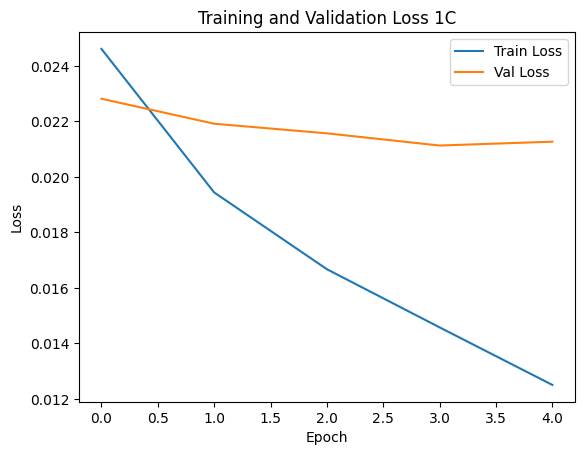

In [18]:

from matplotlib import pyplot as plt
train_losses=epoch_loss
val_losses=l
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss 1C')
plt.legend()
plt.show()

In [19]:
loaded_model = torch.load(f"{model_name}-final.pth")
loaded_model.to(device)
loaded_model.eval()


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [20]:
validation_data = pd.read_csv(f"{PATH}dev.csv",sep="\t")
validation_data
validation_data.dropna(inplace=True)

In [21]:
sentence_set_1 = validation_data['sentence1'].to_numpy()
sentence_set_2 = validation_data['sentence2'].to_numpy()
sentence_set_1.shape,sentence_set_2.shape

((1468,), (1468,))

In [22]:
print(f"Model: {model}")
encode_sentence_set_1 = loaded_model.encode(sentence_set_1, convert_to_tensor=True)
encode_sentence_set_2 = loaded_model.encode(sentence_set_2, convert_to_tensor=True)
loss_fct=torch.nn.MSELoss()
cos_score_transformation=torch.nn.Identity()
cosine_similarities_c = cos_score_transformation(torch.cosine_similarity(encode_sentence_set_1, encode_sentence_set_2))
cosine_similarities = cosine_similarities_c.cpu().detach().numpy()
predicted_scores = []
pairwise_pearson=[]
for i in range(len(cosine_similarities)):
    cos_score = (cosine_similarities[i]+1)/2
    predicted_scores.append(cos_score*5)

score_val = validation_data['score']

data={
    'predicted_score':predicted_scores,
    'original_score':score_val,
    'sentence1':sentence_set_1,
    'sentence2':sentence_set_2
}

final_dataframe = pd.DataFrame(data)
final_dataframe.to_csv("task_1_C.csv")

score_pred_val = final_dataframe['predicted_score']

print(f"Pearson's Coeffecient = {pearsonr(score_val,score_pred_val)[0]}")

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Pearson's Coeffecient = 0.8926744542928413


In [23]:
# torch.cuda.empty_cache()

In [24]:
model = SentenceTransformer(model_name)
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [25]:
print(f"Model: {model}")
encode_sentence_set_1 = model.encode(sentence_set_1, convert_to_tensor=True)
encode_sentence_set_2 = model.encode(sentence_set_2, convert_to_tensor=True)
loss_fct=torch.nn.MSELoss()
cos_score_transformation=torch.nn.Identity()
cosine_similarities_c = cos_score_transformation(torch.cosine_similarity(encode_sentence_set_1, encode_sentence_set_2))
cosine_similarities = cosine_similarities_c.cpu().detach().numpy()
predicted_scores = []
pairwise_pearson=[]
for i in range(len(cosine_similarities)):
    cos_score = (cosine_similarities[i]+1)/2
    predicted_scores.append(cos_score*5)

score_val = validation_data['score']

data={
    'predicted_score':predicted_scores,
    'original_score':score_val,
    'sentence1':sentence_set_1,
    'sentence2':sentence_set_2
}

final_dataframe = pd.DataFrame(data)
final_dataframe.to_csv("task_1_B.csv")

score_pred_val = final_dataframe['predicted_score']

print(f"Pearson's Coeffecient = {pearsonr(score_val,score_pred_val)[0]}")

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Pearson's Coeffecient = 0.8631423819930981
